# lulesh
LULESH represents a typical hydrocode, like ALE3D. LULESH approximates the hydrodynamics equations discretely by partitioning the spatial problem domain into a collection of volumetric elements defined by a mesh. A node on the mesh is a point where mesh lines intersect. LULESH is built on the concept of an unstructured hex mesh. Instead, indirection arrays that define mesh relationships are used.
  
LULESH is a highly simplified application, hard-coded to only solve a simple Sedov blast problem with analytic answers – but represents the numerical algorithms, data motion, and programming style typical in scientific C or C++ based applications.

---
## Parameters 
```
Compiler = icpc (ICC) 18.0.1 20171018
Build_Flags = -g -O3 -march=native -DUSE_MPI=0 -qopenmp -lm
Run_Parameters = -s 40
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

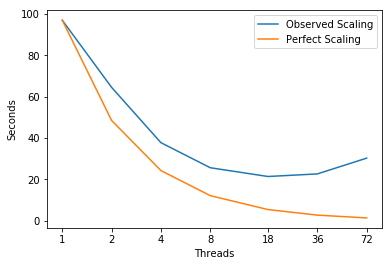

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[97.0, 64.5, 37.75, 25.625, 21.38888888888889, 22.63888888888889, 30.277777777777775],
        label='Observed Scaling')
ax.plot(Threads, [97.0, 48.5, 24.25, 12.125, 5.388888888888889, 2.6944444444444446, 1.3472222222222223],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Intel Software Development Emulator !! Update
| SDE Metrics | miniFE |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.04 |
| **Bytes per Load Inst** | 6.27 |
| **Bytes per Store Inst** | 6.66 |

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz  !!!UPDATE
### 72 Threads - 36 - Cores 2300.0 Mhz
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**  | 143.1 |  44.87 | 33.12 |   16.04  |
|**36 Threads**  | 2509.07 |  807.72 | 558.03 |   58.38  |
|**72 Threads**  | 2391.14 |  792.13 | 581.89 |   42.97  |

---
### Experiment Aggregate Metrics

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (100.0%)|1.49|0.57|0.76|5.40%|2.96%|7.06%|17.55%|18.44%|
|36 (100.0%)|0.89|0.37|0.47|1.75%|23.93%|29.88%|6.06%|5.58%|
|72 (100.0%)|1.38|0.30|0.34|2.26%|23.53|20.59%|14.02%|10.20%|

#### Time spent in kmp_wait_release
|Threads|Time|
|:---:|:---:|
|1|0.0%|
|36|61.6%|
|72|72.0%|


---
### CalcKinematicsForElems( )
outline luclesh.cc:1538

| Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (12.4%)|2.19|0.67|1.04|1.12%|23.97%|12.49%|4.63%|3.47%|
|36 (1.8%)|1.66|0.68|0.97|1.15%|20.87%|24.96%|7.56%|7.56%|
|72 (1.3%)|1.71|0.22|0.34|3.66%|20.91%|39.67%|17.73%|10.16%|

```c++
1532 //static inline
1533 void CalcKinematicsForElems( Domain &domain, Real_t *vnew,
1534                              Real_t deltaTime, Index_t numElem )
1535 {
1536 
1537   // loop over all elements
1538 #pragma omp parallel for firstprivate(numElem, deltaTime)
1539   for( Index_t k=0 ; k<numElem ; ++k )
1540   {
1541     Real_t B[3][8] ; /** shape function derivatives */
1542     Real_t D[6] ;
1543     Real_t x_local[8] ;
1544     Real_t y_local[8] ;
1545     Real_t z_local[8] ;
1546     Real_t xd_local[8] ;
1547     Real_t yd_local[8] ;
1548     Real_t zd_local[8] ;
1549     Real_t detJ = Real_t(0.0) ;
1550 
1551     Real_t volume ;
1552     Real_t relativeVolume ;
1553     const Index_t* const elemToNode = domain.nodelist(k) ;
1554 
1555     // get nodal coordinates from global arrays and copy into local arrays.
1556     CollectDomainNodesToElemNodes(domain, elemToNode, x_local, y_local, z_local);
1557 
1558     // volume calculations
1559     volume = CalcElemVolume(x_local, y_local, z_local );
1560     relativeVolume = volume / domain.volo(k) ;
1561     vnew[k] = relativeVolume ;
1562     domain.delv(k) = relativeVolume - domain.v(k) ;
1563 
1564     // set characteristic length
1565     domain.arealg(k) = CalcElemCharacteristicLength(x_local, y_local, z_local,
1566                                              volume);
1567 
1568     // get nodal velocities from global array and copy into local arrays.
1569     for( Index_t lnode=0 ; lnode<8 ; ++lnode )
1570     {
1571       Index_t gnode = elemToNode[lnode];
1572       xd_local[lnode] = domain.xd(gnode);
1573       yd_local[lnode] = domain.yd(gnode);
1574       zd_local[lnode] = domain.zd(gnode);
1575     }
1576 
1577     Real_t dt2 = Real_t(0.5) * deltaTime;
1578     for ( Index_t j=0 ; j<8 ; ++j )
1579     {
1580        x_local[j] -= dt2 * xd_local[j];
1581        y_local[j] -= dt2 * yd_local[j];
1582        z_local[j] -= dt2 * zd_local[j];
1583     }
1584 
1585     CalcElemShapeFunctionDerivatives( x_local, y_local, z_local,
1586                                       B, &detJ );
1587 
1588     CalcElemVelocityGradient( xd_local, yd_local, zd_local,
1589                                B, detJ, D );
1590 
1591     // put velocity gradient quantities into their global arrays.
1592     domain.dxx(k) = D[0];
1593     domain.dyy(k) = D[1];
1594     domain.dzz(k) = D[2];
1595   }
1596 }
```


---
### CalcFBHourglassForceForElems( )
outline lulesh.cc:810
```c++
 738 static inline
 739 void CalcFBHourglassForceForElems( Domain &domain,
 740                                    Real_t *determ,
 741                                    Real_t *x8n, Real_t *y8n, Real_t *z8n,
 742                                    Real_t *dvdx, Real_t *dvdy, Real_t *dvdz,
 743                                    Real_t hourg, Index_t numElem,
 744                                    Index_t numNode)
 745 {
 746 
 747 #if _OPENMP
 748    Index_t numthreads = omp_get_max_threads();
 749 #else
 750    Index_t numthreads = 1;
 751 #endif
 752    /*************************************************
 753     *
 754     *     FUNCTION: Calculates the Flanagan-Belytschko anti-hourglass
 755     *               force.
 756     *
 757     *************************************************/
 758 
 759    Index_t numElem8 = numElem * 8 ;
 760 
 761    Real_t *fx_elem;
 762    Real_t *fy_elem;
 763    Real_t *fz_elem;
 764 
 765    if(numthreads > 1) {
 766       fx_elem = Allocate<Real_t>(numElem8) ;
 767       fy_elem = Allocate<Real_t>(numElem8) ;
 768       fz_elem = Allocate<Real_t>(numElem8) ;
 769    }
 770 
 771    Real_t  gamma[4][8];
 772 
 773    gamma[0][0] = Real_t( 1.);
 774    gamma[0][1] = Real_t( 1.);
 775    gamma[0][2] = Real_t(-1.);
 776    gamma[0][3] = Real_t(-1.);
 777    gamma[0][4] = Real_t(-1.);
 778    gamma[0][5] = Real_t(-1.);
 779    gamma[0][6] = Real_t( 1.);
 780    gamma[0][7] = Real_t( 1.);
 781    gamma[1][0] = Real_t( 1.);
 782    gamma[1][1] = Real_t(-1.);
 783    gamma[1][2] = Real_t(-1.);
 784    gamma[1][3] = Real_t( 1.);
 785    gamma[1][4] = Real_t(-1.);
 786    gamma[1][5] = Real_t( 1.);
 787    gamma[1][6] = Real_t( 1.);
 788    gamma[1][7] = Real_t(-1.);
 789    gamma[2][0] = Real_t( 1.);
 790    gamma[2][1] = Real_t(-1.);
 791    gamma[2][2] = Real_t( 1.);
 792    gamma[2][3] = Real_t(-1.);
 793    gamma[2][4] = Real_t( 1.);
 794    gamma[2][5] = Real_t(-1.);
 795    gamma[2][6] = Real_t( 1.);
 796    gamma[2][7] = Real_t(-1.);
 797    gamma[3][0] = Real_t(-1.);
 798    gamma[3][1] = Real_t( 1.);
 799    gamma[3][2] = Real_t(-1.);
 800    gamma[3][3] = Real_t( 1.);
 801    gamma[3][4] = Real_t( 1.);
 802    gamma[3][5] = Real_t(-1.);
 803    gamma[3][6] = Real_t( 1.);
 804    gamma[3][7] = Real_t(-1.);
 805 
 806 /*************************************************/
 807 /*    compute the hourglass modes */
 808 
 809 
 ```
 
 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (13.6%)|2.16|0.98|1.27|2.29%|26.28%|59.21%|10.31%|9.71%|
|36 (6.3%)|0.54|0.30|0.37|6.31%|24.86%|20.81%|23.39%|20.13%|
|72 (4.2%)|0.71|0.13|0.16|16.38%|26.17%|17.02%|60.10%|40.01%|
 
 ```c++
 810 #pragma omp parallel for firstprivate(numElem, hourg)
 811    for(Index_t i2=0;i2<numElem;++i2){
 812       Real_t *fx_local, *fy_local, *fz_local ;
 813       Real_t hgfx[8], hgfy[8], hgfz[8] ;
 814 
 815       Real_t coefficient;
 816 
 817       Real_t hourgam[8][4];
 818       Real_t xd1[8], yd1[8], zd1[8] ;
 819 
 820       const Index_t *elemToNode = domain.nodelist(i2);
 821       Index_t i3=8*i2;
 822       Real_t volinv=Real_t(1.0)/determ[i2];
 823       Real_t ss1, mass1, volume13 ;
 824       for(Index_t i1=0;i1<4;++i1){
 825 
 826          Real_t hourmodx =
 827             x8n[i3] * gamma[i1][0] + x8n[i3+1] * gamma[i1][1] +
 828             x8n[i3+2] * gamma[i1][2] + x8n[i3+3] * gamma[i1][3] +
 829             x8n[i3+4] * gamma[i1][4] + x8n[i3+5] * gamma[i1][5] +
 830             x8n[i3+6] * gamma[i1][6] + x8n[i3+7] * gamma[i1][7];
 831 
 832          Real_t hourmody =
 833             y8n[i3] * gamma[i1][0] + y8n[i3+1] * gamma[i1][1] +
 834             y8n[i3+2] * gamma[i1][2] + y8n[i3+3] * gamma[i1][3] +
 835             y8n[i3+4] * gamma[i1][4] + y8n[i3+5] * gamma[i1][5] +
 836             y8n[i3+6] * gamma[i1][6] + y8n[i3+7] * gamma[i1][7];
 837 
 838          Real_t hourmodz =
 839             z8n[i3] * gamma[i1][0] + z8n[i3+1] * gamma[i1][1] +
 840             z8n[i3+2] * gamma[i1][2] + z8n[i3+3] * gamma[i1][3] +
 841             z8n[i3+4] * gamma[i1][4] + z8n[i3+5] * gamma[i1][5] +
 842             z8n[i3+6] * gamma[i1][6] + z8n[i3+7] * gamma[i1][7];
 843 
 844          hourgam[0][i1] = gamma[i1][0] -  volinv*(dvdx[i3  ] * hourmodx +
 845                                                   dvdy[i3  ] * hourmody +
 846                                                   dvdz[i3  ] * hourmodz );
 847 
 848          hourgam[1][i1] = gamma[i1][1] -  volinv*(dvdx[i3+1] * hourmodx +
 849                                                   dvdy[i3+1] * hourmody +
 850                                                   dvdz[i3+1] * hourmodz );
 851 
 852          hourgam[2][i1] = gamma[i1][2] -  volinv*(dvdx[i3+2] * hourmodx +
 853                                                   dvdy[i3+2] * hourmody +
 854                                                   dvdz[i3+2] * hourmodz );
 855 
 856          hourgam[3][i1] = gamma[i1][3] -  volinv*(dvdx[i3+3] * hourmodx +
 857                                                   dvdy[i3+3] * hourmody +
 858                                                   dvdz[i3+3] * hourmodz );
 859 
 860          hourgam[4][i1] = gamma[i1][4] -  volinv*(dvdx[i3+4] * hourmodx +
 861                                                   dvdy[i3+4] * hourmody +
 862                                                   dvdz[i3+4] * hourmodz );
 863 
 864          hourgam[5][i1] = gamma[i1][5] -  volinv*(dvdx[i3+5] * hourmodx +
 865                                                   dvdy[i3+5] * hourmody +
 866                                                   dvdz[i3+5] * hourmodz );
 867 
 868          hourgam[6][i1] = gamma[i1][6] -  volinv*(dvdx[i3+6] * hourmodx +
 869                                                   dvdy[i3+6] * hourmody +
 870                                                   dvdz[i3+6] * hourmodz );
 871 
 872          hourgam[7][i1] = gamma[i1][7] -  volinv*(dvdx[i3+7] * hourmodx +
 873                                                   dvdy[i3+7] * hourmody +
 874                                                   dvdz[i3+7] * hourmodz );
 875 
 876       }
 877 
 878       /* compute forces */
 879       /* store forces into h arrays (force arrays) */
 880 
 881       ss1=domain.ss(i2);
 882       mass1=domain.elemMass(i2);
 883       volume13=CBRT(determ[i2]);
 884 
 885       Index_t n0si2 = elemToNode[0];
 886       Index_t n1si2 = elemToNode[1];
 887       Index_t n2si2 = elemToNode[2];
 888       Index_t n3si2 = elemToNode[3];
 889       Index_t n4si2 = elemToNode[4];
 890       Index_t n5si2 = elemToNode[5];
 891       Index_t n6si2 = elemToNode[6];
 892       Index_t n7si2 = elemToNode[7];
 893 
 894       xd1[0] = domain.xd(n0si2);
 895       xd1[1] = domain.xd(n1si2);
 896       xd1[2] = domain.xd(n2si2);
 897       xd1[3] = domain.xd(n3si2);
 898       xd1[4] = domain.xd(n4si2);
 899       xd1[5] = domain.xd(n5si2);
 900       xd1[6] = domain.xd(n6si2);
 901       xd1[7] = domain.xd(n7si2);
 902 
 903       yd1[0] = domain.yd(n0si2);
 904       yd1[1] = domain.yd(n1si2);
 905       yd1[2] = domain.yd(n2si2);
 906       yd1[3] = domain.yd(n3si2);
 907       yd1[4] = domain.yd(n4si2);
 908       yd1[5] = domain.yd(n5si2);
 909       yd1[6] = domain.yd(n6si2);
 910       yd1[7] = domain.yd(n7si2);
 911 
 912       zd1[0] = domain.zd(n0si2);
 913       zd1[1] = domain.zd(n1si2);
 914       zd1[2] = domain.zd(n2si2);
 915       zd1[3] = domain.zd(n3si2);
 916       zd1[4] = domain.zd(n4si2);
 917       zd1[5] = domain.zd(n5si2);
 918       zd1[6] = domain.zd(n6si2);
 919       zd1[7] = domain.zd(n7si2);
 920 
 921       coefficient = - hourg * Real_t(0.01) * ss1 * mass1 / volume13;
 922 
 923       CalcElemFBHourglassForce(xd1,yd1,zd1,
 924                       hourgam,
 925                       coefficient, hgfx, hgfy, hgfz);
 926 
 927       // With the threaded version, we write into local arrays per elem
 928       // so we don't have to worry about race conditions
 929       if (numthreads > 1) {
 930          fx_local = &fx_elem[i3] ;
 931          fx_local[0] = hgfx[0];
 932          fx_local[1] = hgfx[1];
 933          fx_local[2] = hgfx[2];
 934          fx_local[3] = hgfx[3];
 935          fx_local[4] = hgfx[4];
 936          fx_local[5] = hgfx[5];
 937          fx_local[6] = hgfx[6];
 938          fx_local[7] = hgfx[7];
 939 
 940          fy_local = &fy_elem[i3] ;
 941          fy_local[0] = hgfy[0];
 942          fy_local[1] = hgfy[1];
 943          fy_local[2] = hgfy[2];
 944          fy_local[3] = hgfy[3];
 945          fy_local[4] = hgfy[4];
 946          fy_local[5] = hgfy[5];
 947          fy_local[6] = hgfy[6];
 948          fy_local[7] = hgfy[7];
 949 
 950          fz_local = &fz_elem[i3] ;
 951          fz_local[0] = hgfz[0];
 952          fz_local[1] = hgfz[1];
 953          fz_local[2] = hgfz[2];
 954          fz_local[3] = hgfz[3];
 955          fz_local[4] = hgfz[4];
 956          fz_local[5] = hgfz[5];
 957          fz_local[6] = hgfz[6];
 958          fz_local[7] = hgfz[7];
 959       }
 960       else {
 961          domain.fx(n0si2) += hgfx[0];
 962          domain.fy(n0si2) += hgfy[0];
 963          domain.fz(n0si2) += hgfz[0];
 964 
 965          domain.fx(n1si2) += hgfx[1];
 966          domain.fy(n1si2) += hgfy[1];
 967          domain.fz(n1si2) += hgfz[1];
 968 
 969          domain.fx(n2si2) += hgfx[2];
 970          domain.fy(n2si2) += hgfy[2];
 971          domain.fz(n2si2) += hgfz[2];
 972 
 973          domain.fx(n3si2) += hgfx[3];
 974          domain.fy(n3si2) += hgfy[3];
 975          domain.fz(n3si2) += hgfz[3];
 976 
 977          domain.fx(n4si2) += hgfx[4];
 978          domain.fy(n4si2) += hgfy[4];
 979          domain.fz(n4si2) += hgfz[4];
 980 
 981          domain.fx(n5si2) += hgfx[5];
 982          domain.fy(n5si2) += hgfy[5];
 983          domain.fz(n5si2) += hgfz[5];
 984 
 985          domain.fx(n6si2) += hgfx[6];
 986          domain.fy(n6si2) += hgfy[6];
 987          domain.fz(n6si2) += hgfz[6];
 988 
 989          domain.fx(n7si2) += hgfx[7];
 990          domain.fy(n7si2) += hgfy[7];
 991          domain.fz(n7si2) += hgfz[7];
 992       }
 993    }
 994 
 995    if (numthreads > 1) {
 996      // Collect the data from the local arrays into the final force arrays
 997 #pragma omp parallel for firstprivate(numNode)
 998       for( Index_t gnode=0 ; gnode<numNode ; ++gnode )
 999       {
1000          Index_t count = domain.nodeElemCount(gnode) ;
1001          Index_t *cornerList = domain.nodeElemCornerList(gnode) ;
1002          Real_t fx_tmp = Real_t(0.0) ;
1003          Real_t fy_tmp = Real_t(0.0) ;
1004          Real_t fz_tmp = Real_t(0.0) ;
1005          for (Index_t i=0 ; i < count ; ++i) {
1006             Index_t elem = cornerList[i] ;
1007             fx_tmp += fx_elem[elem] ;
1008             fy_tmp += fy_elem[elem] ;
1009             fz_tmp += fz_elem[elem] ;
1010          }
1011          domain.fx(gnode) += fx_tmp ;
1012          domain.fy(gnode) += fy_tmp ;
1013          domain.fz(gnode) += fz_tmp ;
1014       }
1015       Release(&fz_elem) ;
1016       Release(&fy_elem) ;
1017       Release(&fx_elem) ;
1018    }
1019 }
```

---
### CalcHourglassControlForElems( )
outline lulesh.cc:1037
```c
1023 static inline
1024 void CalcHourglassControlForElems(Domain& domain,
1025                                   Real_t determ[], Real_t hgcoef)
1026 {
1027    Index_t numElem = domain.numElem() ;
1028    Index_t numElem8 = numElem * 8 ;
1029    Real_t *dvdx = Allocate<Real_t>(numElem8) ;
1030    Real_t *dvdy = Allocate<Real_t>(numElem8) ;
1031    Real_t *dvdz = Allocate<Real_t>(numElem8) ;
1032    Real_t *x8n  = Allocate<Real_t>(numElem8) ;
1033    Real_t *y8n  = Allocate<Real_t>(numElem8) ;
1034    Real_t *z8n  = Allocate<Real_t>(numElem8) ;
1035 
1036    /* start loop over elements */
```

|Threads| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (21.8%)|1.01|0.33|0.56|3.43%|19.67%|66.09%|11.93%|7.21%|
|36 (9.7%)|0.40|0.10|0.18|7.00%|22.98%|27.04%|14.12%|11.99%|
|72 (5.5%)|0.51|0.08|0.12|19.03%|22.46%|18.41%|59.55%|37.47%|

```c++
1037 #pragma omp parallel for firstprivate(numElem)
1038    for (Index_t i=0 ; i<numElem ; ++i){
1039       Real_t  x1[8],  y1[8],  z1[8] ;
1040       Real_t pfx[8], pfy[8], pfz[8] ;
1041 
1042       Index_t* elemToNode = domain.nodelist(i);
1043       CollectDomainNodesToElemNodes(domain, elemToNode, x1, y1, z1);
1044 
1045       CalcElemVolumeDerivative(pfx, pfy, pfz, x1, y1, z1);
1046 
1047       /* load into temporary storage for FB Hour Glass control */
1048       for(Index_t ii=0;ii<8;++ii){
1049          Index_t jj=8*i+ii;
1050 
1051          dvdx[jj] = pfx[ii];
1052          dvdy[jj] = pfy[ii];
1053          dvdz[jj] = pfz[ii];
1054          x8n[jj]  = x1[ii];
1055          y8n[jj]  = y1[ii];
1056          z8n[jj]  = z1[ii];
1057       }
1058 
1059       determ[i] = domain.volo(i) * domain.v(i);
1060 
1061       /* Do a check for negative volumes */
1062       if ( domain.v(i) <= Real_t(0.0) ) {
1063 #if USE_MPI         
1064          MPI_Abort(MPI_COMM_WORLD, VolumeError) ;
1065 #else
1066          exit(VolumeError);
1067 #endif
1068       }
1069    }
1070 
1071    if ( hgcoef > Real_t(0.) ) {
1072       CalcFBHourglassForceForElems( domain,
1073                                     determ, x8n, y8n, z8n, dvdx, dvdy, dvdz,
1074                                     hgcoef, numElem, domain.numNode()) ;
1075    }
1076 
1077    Release(&z8n) ;
1078    Release(&y8n) ;
1079    Release(&x8n) ;
1080    Release(&dvdz) ;
1081    Release(&dvdy) ;
1082    Release(&dvdx) ;
1083 
1084    return ;
1085 }
```

---
### IntegrateStressForElems( )
outline lulesh.cc:549
```c++
 522 static inline
 523 void IntegrateStressForElems( Domain &domain,
 524                               Real_t *sigxx, Real_t *sigyy, Real_t *sigzz,
 525                               Real_t *determ, Index_t numElem, Index_t numNode)
 526 {
 527 #if _OPENMP
 528    Index_t numthreads = omp_get_max_threads();
 529 #else
 530    Index_t numthreads = 1;
 531 #endif
 532 
 533    Index_t numElem8 = numElem * 8 ;
 534    Real_t *fx_elem;
 535    Real_t *fy_elem;
 536    Real_t *fz_elem;
 537    Real_t fx_local[8] ;
 538    Real_t fy_local[8] ;
 539    Real_t fz_local[8] ;
 540 
 541 
 542   if (numthreads > 1) {
 543      fx_elem = Allocate<Real_t>(numElem8) ;
 544      fy_elem = Allocate<Real_t>(numElem8) ;
 545      fz_elem = Allocate<Real_t>(numElem8) ;
 546   }
 547   // loop over all elements
 548 
 ```
 
  |Threads| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (11.4%)|2.40|0.84|1.29|0.61%|26.19%|1.60%|3.25%|3.08%|
|36 (3.8%)|0.71|0.29|0.44|3.94%|26.10%|29.58%|16.97%|15.38%|
|72 (3.1%)|0.97|0.14|0.20|13.56|23.45%|9.02%|70.43%|44.07%|

 ```c++
 549 #pragma omp parallel for firstprivate(numElem)
 550   for( Index_t k=0 ; k<numElem ; ++k )
 551   {
 552     const Index_t* const elemToNode = domain.nodelist(k);
 553     Real_t B[3][8] ;// shape function derivatives
 554     Real_t x_local[8] ;
 555     Real_t y_local[8] ;
 556     Real_t z_local[8] ;
 557 
 558     // get nodal coordinates from global arrays and copy into local arrays.
 559     CollectDomainNodesToElemNodes(domain, elemToNode, x_local, y_local, z_local);
 560 
 561     // Volume calculation involves extra work for numerical consistency
 562     CalcElemShapeFunctionDerivatives(x_local, y_local, z_local,
 563                                          B, &determ[k]);
 564 
 565     CalcElemNodeNormals( B[0] , B[1], B[2],
 566                           x_local, y_local, z_local );
 567 
 568     if (numthreads > 1) {
 569        // Eliminate thread writing conflicts at the nodes by giving
 570        // each element its own copy to write to
 571        SumElemStressesToNodeForces( B, sigxx[k], sigyy[k], sigzz[k],
 572                                     &fx_elem[k*8],
 573                                     &fy_elem[k*8],
 574                                     &fz_elem[k*8] ) ;
 575     }
 576     else {
 577        SumElemStressesToNodeForces( B, sigxx[k], sigyy[k], sigzz[k],
 578                                     fx_local, fy_local, fz_local ) ;
 579 
 580        // copy nodal force contributions to global force arrray.
 581        for( Index_t lnode=0 ; lnode<8 ; ++lnode ) {
 582           Index_t gnode = elemToNode[lnode];
 583           domain.fx(gnode) += fx_local[lnode];
 584           domain.fy(gnode) += fy_local[lnode];
 585           domain.fz(gnode) += fz_local[lnode];
 586        }
 587     }
 588   }
 589 
 590   if (numthreads > 1) {
 591      // If threaded, then we need to copy the data out of the temporary
 592      // arrays used above into the final forces field
 593 #pragma omp parallel for firstprivate(numNode)
 594      for( Index_t gnode=0 ; gnode<numNode ; ++gnode )
 595      {
 596         Index_t count = domain.nodeElemCount(gnode) ;
 597         Index_t *cornerList = domain.nodeElemCornerList(gnode) ;
 598         Real_t fx_tmp = Real_t(0.0) ;
 599         Real_t fy_tmp = Real_t(0.0) ;
 600         Real_t fz_tmp = Real_t(0.0) ;
 601         for (Index_t i=0 ; i < count ; ++i) {
 602            Index_t elem = cornerList[i] ;
 603            fx_tmp += fx_elem[elem] ;
 604            fy_tmp += fy_elem[elem] ;
 605            fz_tmp += fz_elem[elem] ;
 606         }
 607         domain.fx(gnode) = fx_tmp ;
 608         domain.fy(gnode) = fy_tmp ;
 609         domain.fz(gnode) = fz_tmp ;
 610      }
 611      Release(&fz_elem) ;
 612      Release(&fy_elem) ;
 613      Release(&fx_elem) ;
 614   }
 615 }
```

---
### CalcMonotonicQGradientsForElems( )
outline lulesh.cc:1646
```c++
1641 static inline
1642 void CalcMonotonicQGradientsForElems(Domain& domain, Real_t vnew[])
1643 {
1644    Index_t numElem = domain.numElem();
1645 
```

 |Threads| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (7.8%)|1.61|0.72|0.82|2.35%|24.59%|0.77%|7.32%|6.67%|
|36 (1.4%)|1.44|0.57|0.68|2.06%|26.13%|4.78%|10.84%|10.29%|
|72 (0.9%)|1.19|0.29|0.32|8.06%|21.88%|4.99%|39.67%|23.08%|

```c++
1646 #pragma omp parallel for firstprivate(numElem)
1647    for (Index_t i = 0 ; i < numElem ; ++i ) {
1648       const Real_t ptiny = Real_t(1.e-36) ;
1649       Real_t ax,ay,az ;
1650       Real_t dxv,dyv,dzv ;
1651 
1652       const Index_t *elemToNode = domain.nodelist(i);
1653       Index_t n0 = elemToNode[0] ;
1654       Index_t n1 = elemToNode[1] ;
1655       Index_t n2 = elemToNode[2] ;
1656       Index_t n3 = elemToNode[3] ;
1657       Index_t n4 = elemToNode[4] ;
1658       Index_t n5 = elemToNode[5] ;
1659       Index_t n6 = elemToNode[6] ;
1660       Index_t n7 = elemToNode[7] ;
1661 
1662       Real_t x0 = domain.x(n0) ;
1663       Real_t x1 = domain.x(n1) ;
1664       Real_t x2 = domain.x(n2) ;
1665       Real_t x3 = domain.x(n3) ;
1666       Real_t x4 = domain.x(n4) ;
1667       Real_t x5 = domain.x(n5) ;
1668       Real_t x6 = domain.x(n6) ;
1669       Real_t x7 = domain.x(n7) ;
1670 
1671       Real_t y0 = domain.y(n0) ;
1672       Real_t y1 = domain.y(n1) ;
1673       Real_t y2 = domain.y(n2) ;
1674       Real_t y3 = domain.y(n3) ;
1675       Real_t y4 = domain.y(n4) ;
1676       Real_t y5 = domain.y(n5) ;
1677       Real_t y6 = domain.y(n6) ;
1678       Real_t y7 = domain.y(n7) ;
1679 
1680       Real_t z0 = domain.z(n0) ;
1681       Real_t z1 = domain.z(n1) ;
1682       Real_t z2 = domain.z(n2) ;
1683       Real_t z3 = domain.z(n3) ;
1684       Real_t z4 = domain.z(n4) ;
1685       Real_t z5 = domain.z(n5) ;
1686       Real_t z6 = domain.z(n6) ;
1687       Real_t z7 = domain.z(n7) ;
1688 
1689       Real_t xv0 = domain.xd(n0) ;
1690       Real_t xv1 = domain.xd(n1) ;
1691       Real_t xv2 = domain.xd(n2) ;
1692       Real_t xv3 = domain.xd(n3) ;
1693       Real_t xv4 = domain.xd(n4) ;
1694       Real_t xv5 = domain.xd(n5) ;
1695       Real_t xv6 = domain.xd(n6) ;
1696       Real_t xv7 = domain.xd(n7) ;
1697 
1698       Real_t yv0 = domain.yd(n0) ;
1699       Real_t yv1 = domain.yd(n1) ;
1700       Real_t yv2 = domain.yd(n2) ;
1701       Real_t yv3 = domain.yd(n3) ;
1702       Real_t yv4 = domain.yd(n4) ;
1703       Real_t yv5 = domain.yd(n5) ;
1704       Real_t yv6 = domain.yd(n6) ;
1705       Real_t yv7 = domain.yd(n7) ;
1706 
1707       Real_t zv0 = domain.zd(n0) ;
1708       Real_t zv1 = domain.zd(n1) ;
1709       Real_t zv2 = domain.zd(n2) ;
1710       Real_t zv3 = domain.zd(n3) ;
1711       Real_t zv4 = domain.zd(n4) ;
1712       Real_t zv5 = domain.zd(n5) ;
1713       Real_t zv6 = domain.zd(n6) ;
1714       Real_t zv7 = domain.zd(n7) ;
1715 
1716       Real_t vol = domain.volo(i)*vnew[i] ;
1717       Real_t norm = Real_t(1.0) / ( vol + ptiny ) ;
1718 
1719       Real_t dxj = Real_t(-0.25)*((x0+x1+x5+x4) - (x3+x2+x6+x7)) ;
1720       Real_t dyj = Real_t(-0.25)*((y0+y1+y5+y4) - (y3+y2+y6+y7)) ;
1721       Real_t dzj = Real_t(-0.25)*((z0+z1+z5+z4) - (z3+z2+z6+z7)) ;
1722 
1723       Real_t dxi = Real_t( 0.25)*((x1+x2+x6+x5) - (x0+x3+x7+x4)) ;
1724       Real_t dyi = Real_t( 0.25)*((y1+y2+y6+y5) - (y0+y3+y7+y4)) ;
1725       Real_t dzi = Real_t( 0.25)*((z1+z2+z6+z5) - (z0+z3+z7+z4)) ;
1726 
1727       Real_t dxk = Real_t( 0.25)*((x4+x5+x6+x7) - (x0+x1+x2+x3)) ;
1728       Real_t dyk = Real_t( 0.25)*((y4+y5+y6+y7) - (y0+y1+y2+y3)) ;
1729       Real_t dzk = Real_t( 0.25)*((z4+z5+z6+z7) - (z0+z1+z2+z3)) ;
1730 
1731       /* find delvk and delxk ( i cross j ) */
1732 
1733       ax = dyi*dzj - dzi*dyj ;
1734       ay = dzi*dxj - dxi*dzj ;
1735       az = dxi*dyj - dyi*dxj ;
1736 
1737       domain.delx_zeta(i) = vol / SQRT(ax*ax + ay*ay + az*az + ptiny) ;
1738 
1739       ax *= norm ;
1740       ay *= norm ;
1741       az *= norm ;
1742 
1743       dxv = Real_t(0.25)*((xv4+xv5+xv6+xv7) - (xv0+xv1+xv2+xv3)) ;
1744       dyv = Real_t(0.25)*((yv4+yv5+yv6+yv7) - (yv0+yv1+yv2+yv3)) ;
1745       dzv = Real_t(0.25)*((zv4+zv5+zv6+zv7) - (zv0+zv1+zv2+zv3)) ;
1746 
1747       domain.delv_zeta(i) = ax*dxv + ay*dyv + az*dzv ;
1748 
1749       /* find delxi and delvi ( j cross k ) */
1750 
1751       ax = dyj*dzk - dzj*dyk ;
1752       ay = dzj*dxk - dxj*dzk ;
1753       az = dxj*dyk - dyj*dxk ;
1754 
1755       domain.delx_xi(i) = vol / SQRT(ax*ax + ay*ay + az*az + ptiny) ;
1756 
1757       ax *= norm ;
1758       ay *= norm ;
1759       az *= norm ;
1760 
1761       dxv = Real_t(0.25)*((xv1+xv2+xv6+xv5) - (xv0+xv3+xv7+xv4)) ;
1762       dyv = Real_t(0.25)*((yv1+yv2+yv6+yv5) - (yv0+yv3+yv7+yv4)) ;
1763       dzv = Real_t(0.25)*((zv1+zv2+zv6+zv5) - (zv0+zv3+zv7+zv4)) ;
1764 
1765       domain.delv_xi(i) = ax*dxv + ay*dyv + az*dzv ;
1766 
1767       /* find delxj and delvj ( k cross i ) */
1768 
1769       ax = dyk*dzi - dzk*dyi ;
1770       ay = dzk*dxi - dxk*dzi ;
1771       az = dxk*dyi - dyk*dxi ;
1772 
1773       domain.delx_eta(i) = vol / SQRT(ax*ax + ay*ay + az*az + ptiny) ;
1774 
1775       ax *= norm ;
1776       ay *= norm ;
1777       az *= norm ;
1778 
1779       dxv = Real_t(-0.25)*((xv0+xv1+xv5+xv4) - (xv3+xv2+xv6+xv7)) ;
1780       dyv = Real_t(-0.25)*((yv0+yv1+yv5+yv4) - (yv3+yv2+yv6+yv7)) ;
1781       dzv = Real_t(-0.25)*((zv0+zv1+zv5+zv4) - (zv3+zv2+zv6+zv7)) ;
1782 
1783       domain.delv_eta(i) = ax*dxv + ay*dyv + az*dzv ;
1784    }
1785 }
```

---
### EvalEOSForElems( )
outline lulesh.cc:2269

```c++
2233 static inline
2234 void EvalEOSForElems(Domain& domain, Real_t *vnewc,
2235                      Int_t numElemReg, Index_t *regElemList, Int_t rep)
2236 {
2237    Real_t  e_cut = domain.e_cut() ;
2238    Real_t  p_cut = domain.p_cut() ;
2239    Real_t  ss4o3 = domain.ss4o3() ;
2240    Real_t  q_cut = domain.q_cut() ;
2241 
2242    Real_t eosvmax = domain.eosvmax() ;
2243    Real_t eosvmin = domain.eosvmin() ;
2244    Real_t pmin    = domain.pmin() ;
2245    Real_t emin    = domain.emin() ;
2246    Real_t rho0    = domain.refdens() ;
2247 
2248    // These temporaries will be of different size for 
2249    // each call (due to different sized region element
2250    // lists)
2251    Real_t *e_old = Allocate<Real_t>(numElemReg) ;
2252    Real_t *delvc = Allocate<Real_t>(numElemReg) ;
2253    Real_t *p_old = Allocate<Real_t>(numElemReg) ;
2254    Real_t *q_old = Allocate<Real_t>(numElemReg) ;
2255    Real_t *compression = Allocate<Real_t>(numElemReg) ;
2256    Real_t *compHalfStep = Allocate<Real_t>(numElemReg) ;
2257    Real_t *qq_old = Allocate<Real_t>(numElemReg) ;
2258    Real_t *ql_old = Allocate<Real_t>(numElemReg) ;
2259    Real_t *work = Allocate<Real_t>(numElemReg) ;
2260    Real_t *p_new = Allocate<Real_t>(numElemReg) ;
2261    Real_t *e_new = Allocate<Real_t>(numElemReg) ;
2262    Real_t *q_new = Allocate<Real_t>(numElemReg) ;
2263    Real_t *bvc = Allocate<Real_t>(numElemReg) ;
2264    Real_t *pbvc = Allocate<Real_t>(numElemReg) ;
2265 
2266    //loop to add load imbalance based on region number 
2267    for(Int_t j = 0; j < rep; j++) {
2268       /* compress data, minimal set */
```

 |Threads| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (6.2%)|0.77|0.43|0.41|20.9%|31.41%|1.73%|44.59%|52.35%|
|36 (4.0%)|0.67|0.42|0.47|2.78%|21.22%|35.07%|8.99%|7.64%|
|72 (4.4%)|1.24|0.37|0.41|3.05%|25.46%|15.40%|23.31%|20.49%|

```c++
2269 #pragma omp parallel
2270       {
2271 #pragma omp for nowait firstprivate(numElemReg)
2272          for (Index_t i=0; i<numElemReg; ++i) {
2273             Index_t elem = regElemList[i];
2274             e_old[i] = domain.e(elem) ;
2275             delvc[i] = domain.delv(elem) ;
2276             p_old[i] = domain.p(elem) ;
2277             q_old[i] = domain.q(elem) ;
2278             qq_old[i] = domain.qq(elem) ;
2279             ql_old[i] = domain.ql(elem) ;
2280          }
2281 
2282 #pragma omp for firstprivate(numElemReg)
2283          for (Index_t i = 0; i < numElemReg ; ++i) {
2284             Index_t elem = regElemList[i];
2285             Real_t vchalf ;
2286             compression[i] = Real_t(1.) / vnewc[elem] - Real_t(1.);
2287             vchalf = vnewc[elem] - delvc[i] * Real_t(.5);
2288             compHalfStep[i] = Real_t(1.) / vchalf - Real_t(1.);
2289          }
2290 
2291       /* Check for v > eosvmax or v < eosvmin */
2292          if ( eosvmin != Real_t(0.) ) {
2293 #pragma omp for nowait firstprivate(numElemReg, eosvmin)
2294             for(Index_t i=0 ; i<numElemReg ; ++i) {
2295                Index_t elem = regElemList[i];
2296                if (vnewc[elem] <= eosvmin) { /* impossible due to calling func? */
2297                   compHalfStep[i] = compression[i] ;
2298                }
2299             }
2300          }
2301          if ( eosvmax != Real_t(0.) ) {
2302 #pragma omp for nowait firstprivate(numElemReg, eosvmax)
2303             for(Index_t i=0 ; i<numElemReg ; ++i) {
2304                Index_t elem = regElemList[i];
2305                if (vnewc[elem] >= eosvmax) { /* impossible due to calling func? */
2306                   p_old[i]        = Real_t(0.) ;
2307                   compression[i]  = Real_t(0.) ;
2308                   compHalfStep[i] = Real_t(0.) ;
2309                }
2310             }
2311          }
2312 
2313 #pragma omp for nowait firstprivate(numElemReg)
2314          for (Index_t i = 0 ; i < numElemReg ; ++i) {
2315             work[i] = Real_t(0.) ;
2316          }
2317       }
2318       CalcEnergyForElems(p_new, e_new, q_new, bvc, pbvc,
2319                          p_old, e_old,  q_old, compression, compHalfStep,
2320                          vnewc, work,  delvc, pmin,
2321                          p_cut, e_cut, q_cut, emin,
2322                          qq_old, ql_old, rho0, eosvmax,
2323                          numElemReg, regElemList);
2324    }
2325 
2326 #pragma omp parallel for firstprivate(numElemReg)
2327    for (Index_t i=0; i<numElemReg; ++i) {
2328       Index_t elem = regElemList[i];
2329       domain.p(elem) = p_new[i] ;
2330       domain.e(elem) = e_new[i] ;
2331       domain.q(elem) = q_new[i] ;
2332    }
2333 
2334    CalcSoundSpeedForElems(domain,
2335                           vnewc, rho0, e_new, p_new,
2336                           pbvc, bvc, ss4o3,
2337                           numElemReg, regElemList) ;
2338 
2339    Release(&pbvc) ;
2340    Release(&bvc) ;
2341    Release(&q_new) ;
2342    Release(&e_new) ;
2343    Release(&p_new) ;
2344    Release(&work) ;
2345    Release(&ql_old) ;
2346    Release(&qq_old) ;
2347    Release(&compHalfStep) ;
2348    Release(&compression) ;
2349    Release(&q_old) ;
2350    Release(&p_old) ;
2351    Release(&delvc) ;
2352    Release(&e_old) ;
2353 }
```

## Discussion - Scales into large amount of waiting. Several kernels become bandwidth bound
Interesting OpenMP application, manual parallel region expansion and barrier elimination.  Showing majority of time in omp wait_release().  Problem fits in L3 on 1 Thread?  DRAM Bandwidth not shown, always under 2%.
  
Interesting scaling on individual parallel regions.  Several show higher loss in performance due to a loss of locality (L1 Miss Ratio going up bringing L2 and L3 bandwidth used up).  Harmful loop unrolling? (unrolling the first index)